# Finding Best Quartic Fit - 2 dot system

The Goal of this tutorial is to demonstrate the `fit_quartic()` function as it creates a quartic potential well of best fit.

**Section 0.0 `fit_quartic()` Function**
> Details about the fit function to note before the tutorial

**Section 1.0 Basic Fit Example**
> Creating a basic quartic potential well with the same parameters as the fitted well to check for validity. 
We will compare parameter values and plot the potentials.

**Section 2.0 Adding Complexity**
> Creating a slightly more complex well and adding noise to demonstrate the functions ability to smooth the data and create the potential of best fit

# Section 0.0 - `fit_quartic()` Function

First, Import all of the needed modules

In [1]:
import os
from pathlib import Path
path = Path(os.getcwd())

# update base working directory to QuDiPy
if path.stem != 'QuDiPy':
    base_dir = path.parents[1]
    os.chdir(base_dir)
else:
    base_dir = path

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from qudipy.utils import constants
from qudipy.potential.manipulate import fit_quartic
from qudipy.potential import GridParameters

### 0.1 How is the data being fit?

The data is being fit to the following quartic function:  

$$
U_{fit}(x,y) = \frac{m^* \omega_0^2}{2}\left(\frac{[(x-x_c)^2-d^2]^2}{4d^2} + (y - y_c)^2\right) + e \mathscr{E} (x-x_c) + U_0
$$
Here, $m^*$ and $e$ are the electron effective mass and charge, respectively, whereas the fitting parameters are:
- $(x_c, y_c)$ is the position of the center of the double-dot potential  
- $\omega_0$ determines the effective widths of the quantum dots $\sqrt{\hbar/m^*\omega_0}$
- $2 d$ is the dot seperation  
- $\mathscr{E}$ is the electric field along $x$ axis, i.e., the major axis connecting two dots
- $U_0$ is the average lowest energy of the two valleys (zero-energy level) 


**The fitting procedure** is performed on a pair of quantum dots.


We consider the case when the bias is small compared to the electron confinement energy: this ensures charge stability, among other things. Therefore, $\zeta = \frac{e \mathscr{E}d}{m^* \omega_0^2 d^2} \ll 1$ is treated as a small parameter.


> 1. $y_c$ is found at the position of the _global minimum_ of $U_{fit}(x,y)$.
 
All further calculations are done for the 1D slice $U(x) \equiv U_{fit}(x, y=y_c)$


  
> 2. Finding the local minima (approximated by two parabolas) and evaluating potential energies there: 

$$
    x_{1,2} = x_c \mp d - \frac{e \mathscr{E}}{m^* \omega_0^2} + o(\zeta), 
        \qquad U_{1,2}  = U_0 \mp e \mathscr{E} d 
    - \frac{(e \mathscr{E})^2}{2 m^* \omega_0^2 } + o(\zeta^2)
$$

We obtain the estimate for $d$ up to $o(\zeta)$ directly from here :
$
   \quad \color{indigo} d \approx \dfrac{x_1 + x_2}{2} 
$

> 3. Rewriting $U(x)$ to find the local maximum (saddle point in 2D):
$$
    U(x) = U_0 + \frac{m^* \omega_0^2 d^2}{8} + 
        \frac{m^* \omega_0^2}{8 d^2} (x - x_c)^4 
            - \frac{m^* \omega_0^2 }{4}
                \left(x - x_c - \frac{2 e \mathscr{E}}{m^* \omega_0^2}\right)^2
                    + \frac{(e \mathscr{E})^2}{ m^* \omega_0^2 }
$$

In case of no bias ($\mathscr{E}=0$), obviously, $x_{max}=x_c$. Since the quadratic term dominates over the quartic one for small values of $x - x_c$, 
we conclude that the local maximum is approximately determined by the quadratic term: 

$$
    x_{max} = x_c + \frac{2 e \mathscr{E}}{m^* \omega_0^2} + o(\zeta), 
    \qquad 
    U_{max} = U(x_{max}) = U_0 + \frac{m^* \omega_0^2 d^2}{8 } 
                    + \frac{(e \mathscr{E})^2}{ m^* \omega_0^2 } + o(\zeta^2)
$$


> 4. Rewriting expressions for $x_1, x_2, x_{max}$ to estimate $x_c$ to the highest order of $\zeta$:
$$
    \mathrm{add\ two\ equations:}\quad \begin{cases} x_1 + x_2 = 2 x_c - \frac{2 e \mathscr{E}}{ m^* \omega_0^2 } + o(\zeta) \\
                x_{max} = x_c + \frac{2 e \mathscr{E}}{m^* \omega_0^2} + o(\zeta) 
    \end{cases} 
    \quad \Rightarrow \quad \color{indigo} x_c \approx \frac{x_1 + x_2 + x_{max}}{3}
$$


> 5. Rewriting expressions for $U_1, U_2, U_{max}$ to estimate $U_0, \omega_0$ to the highest order of $\zeta$:

Eliminating $U_0$ gives a quadratic equation for $\color{indigo} m^* \omega_0^2$:
$$ 
    U_{max} - \frac{U_1 + U_2}{2} = \frac{m^* \omega_0^2 d^2}{8 } + \frac{3}{2} \frac{(e \mathscr{E})^2}{ m^* \omega_0^2 } + o(\zeta^2)   
$$
$$
 \Rightarrow \quad    \color{indigo} \omega_0 \approx 
    \sqrt{\frac{1}{2 m^*}\left(k + \sqrt{k^2 - 6 (e \mathscr{E})^2}\right)}, 
        \quad  {\color{gray}\mathrm{where}} \quad
              k = \frac{4}{d^2} \left(2U_{max} - U_1 - U_2\right)
$$

Then, having eliminated the explicit term with $\mathscr{E}$, we find the expression for $U_0$:
$$
    U_{max} + (U_1 + U_2) = 3 U_0 + \frac{m^* \omega_0^2 d^2}{8 } + o(\zeta^2)
        \\ \Rightarrow  \quad \color{indigo}
            U_0 \approx \frac{U_{max} + U_1 + U_2}{3} - \frac{m^* \omega_0^2 d^2}{24}
$$

### 0.2 What is the `fit_quartic()` Function
To find the potential of best fit we must call the **'quartic'** function from the **potential.manipulate.py** module. The function has the following parameters and Optional Parameters:

`quartic(U_data, gparams, y_slice=0, material='vacuum', return_params=False)`

 **Parameters**   
> - `U_data` = 2D array of potential data to be fit   
> - `gparams` = GridParameters object (follow path qudipy.potential.grid_params.py for more)  

**Optional Parameters**  
> - `y_slice=0` = The y value that the well is centered on, default is at 0   
> - `material='vacuum'` = The material used. Default is vacuum   
> - `return_params=False` = The predicate to determine if the user wishes to return a dictionary of parameter values. Default is `False`, and the function will return the 2D array of best fitting potential values.   


***
**keys for return_params=True**
> When `return_params=True` the function will return a dictionary with parameter values inside. The following are the keys used to call out these parameters. If `return_params=False`, the function will return the 2D Array of fit values:
> - <font color=green>'U_fit'</font> : 2D Array of fitted potential values  
> - <font color=green>'dot_sep'</font> : dot_seperation 
> - <font color=green>'e_field_x'</font> : electric field along $x$ axis
> - <font color=green>'omega_0'</font>: characteristic width of the 2-well potential
> - <font color=green>'x_centre'</font> : centre of the 2-well potential
> - <font color=green>'U_0'</font> : zero energy level


# Section 1.0 Basic Fit Example

### 1.1 Create Potential Data

First, let's create a 2D Array of potential values that we will pass to the fitting function. Let us create a potential identiсal to the fitting function so that we may verify our values.

Let's create a well of the shape specified in *0.1* so that we can test that the fitted well gives us back the same potentails.
To avoid numerical errors, all values shall be specified in SI!

In [3]:
# Create Parameters for Data Potential
d = 30e-9 # half dot seperation (initial guess)
E1 = 2e-19 # min Energy of first well
E2 = 2e-19 # min Energy of second well
Emax = 3e-19 # Energy at local max
U0 = (E2 + E1) / 2 # average lowest energy
e = constants.e # electron charge
mat_system = constants.select_material('Si/SiO2')
m = mat_system.me # electron effective mass
epsilon = (E2 - E1)/(e * 2 * d) # electric field along x axis
omega0 = 2/d * np.sqrt((1/m)*(2*Emax - E2 - E1)) # quartic potential at x0
x0 = 0

# x and y values
x = np.linspace(-2*d, 2*d, 100, endpoint=True)
y = np.linspace(-2*d, 2*d, 100, endpoint=True)
x_vals, y_vals = np.meshgrid(x,y, indexing='xy')


U_data = (m * omega0**2)/2 *\
            (np.square(np.square(x_vals - x0) - d**2) / (4*d**2) + np.square(y_vals)) +\
            epsilon * e * x_vals + U0

### 1.2 Graph the data plots

Next, graph `U_data`, the potential that we wish to have fitted. 

Below we have plotted `x` vs. `U`, `y` vs. `U`, `xy` vs. `U` and a 3D plot of the potential to provide an in depth view of the potential that we will pass to the fitting function.

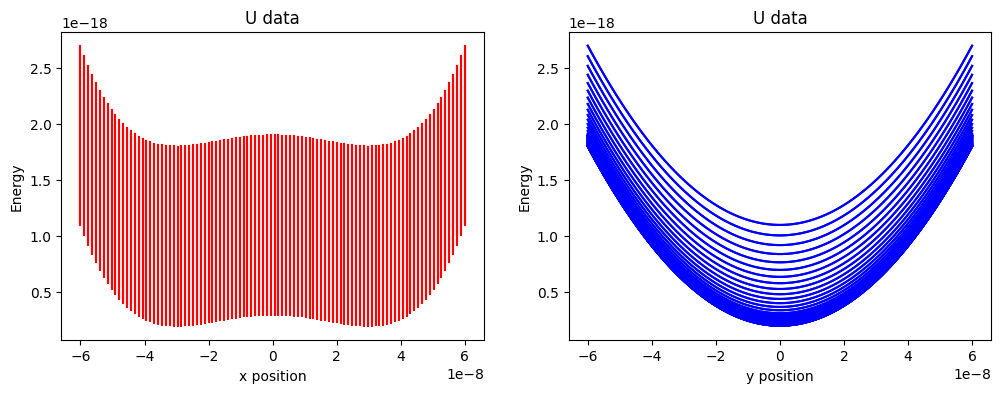

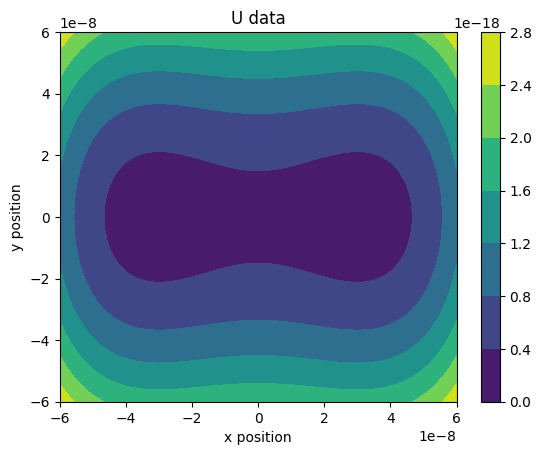

Text(0.5, 0.92, 'Quartic Potential')

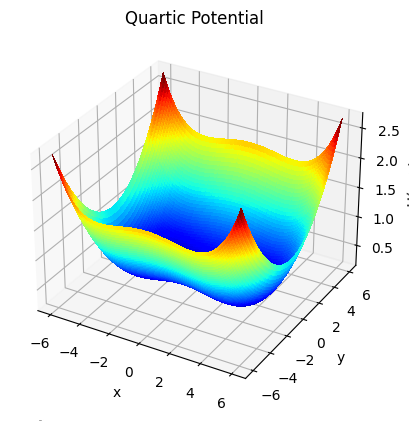

In [4]:
# Graph the data

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

# Potential - x vs. U
ax1.plot(x_vals, U_data, 'r')
ax1.set_xlabel('x position')
ax1.set_ylabel('Energy')
ax1.set_title('U data')

# Potential - y vs. U
ax2.plot(y_vals, U_data, 'b')
ax2.set_xlabel('y position')
ax2.set_ylabel('Energy')
ax2.set_title('U data')

plt.show()

# Potential - xy vs. U
plt.contourf(x,y, U_data)
plt.colorbar()
plt.title('U data')
plt.xlabel('x position')
plt.ylabel('y position')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x_vals, y_vals, U_data, rstride=1, cstride=1,
                       cmap=plt.cm.jet, linewidth=0, antialiased=False)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('U(x, y)')
ax.set_title('Quartic Potential')

### 1.3 Find quartic well of best fit

We will now use the `fit_quartic()` function to find the potential of best fit. We will compare the optimized parameters next to the parameters that we created the data from to verify that our function has suceeded in finding the appropriate parameters of best fit.

In [5]:
# x and y coordinates same as the coords from our data
x = np.linspace(-2*d, 2*d, 100, endpoint=True)
y = np.linspace(-2*d, 2*d, 100, endpoint=True)
x_vals, y_vals = np.meshgrid(x,y, indexing='xy')
gparams = GridParameters(x, y)
gparams.update_potential(U_data)

# Pass all information to fitting function
U_fit_dict = fit_quartic(gparams,  material='Si/SiO2', return_params=True)

# Retrieve parameters
U_fit = U_fit_dict['U_fit']
d_fit = U_fit_dict['dot_sep']
epsilon_fit = U_fit_dict['e_field_x']
omega0_fit = U_fit_dict['omega_0']
x0_fit = U_fit_dict['x_centre']
U0_fit = U_fit_dict['U_0']

# Print off parameter values and compare with created potential parameter values
info_dict = {'dot_sep': [d_fit, d, 100*abs(d_fit - d)/d], 'e_field_x': [epsilon_fit, epsilon, abs(epsilon_fit - epsilon)], \
                'omega_0':[omega0_fit, omega0, 100*abs(omega0_fit - omega0)/omega0], 'x_centre': [x0_fit, x0, abs(x0_fit - x0)], \
                                                        'U_0': [U0_fit, U0, 100*abs(U0_fit - U0)/U0]}
df = pd.DataFrame(data=info_dict, index=['fit', 'data', 'difference'])
display(df)

,dot_sep,e_field_x,omega_0,x_centre,U_0
fit,6.000009e-08,-4.332458e-07,7.147627e+13,-6.662899e-16,2.001632e-19
data,3.000000e-08,0.000000e+00,7.147638e+13,0.000000e+00,2.000000e-19
difference,1.000003e+02,4.332458e-07,1.508734e-04,6.662899e-16,8.161965e-02


### 1.4 Graph The Quartic Potential of Best Fit

We will now graph `U_fit`

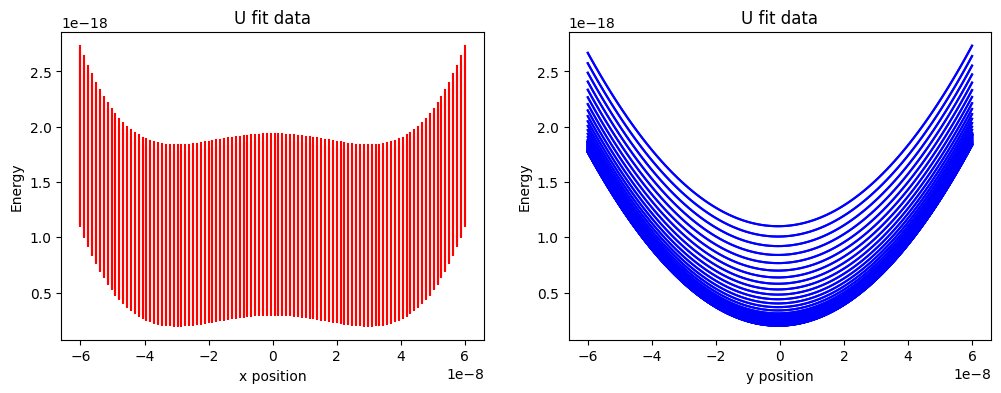

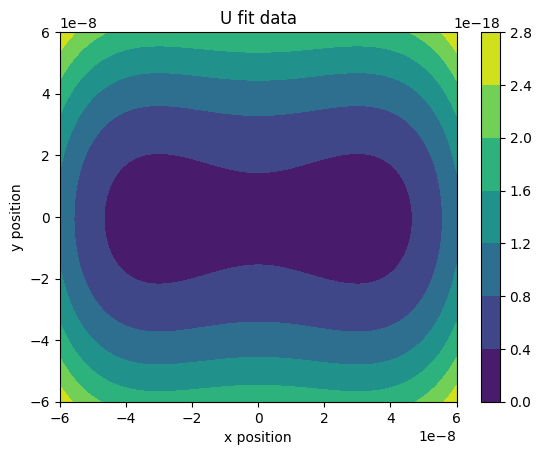

Text(0.5, 0.92, 'Quartic Potential of best Fit')

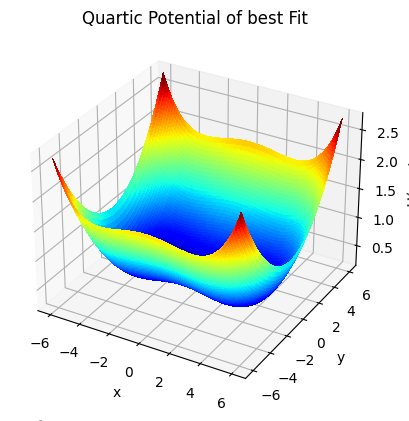

In [6]:
# Graph the fitted potential

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

# Potential - x vs. U
ax1.plot(x_vals, U_fit, 'r')
ax1.set_xlabel('x position')
ax1.set_ylabel('Energy')
ax1.set_title('U fit data')

# Potential - y vs. U
ax2.plot(y_vals, U_fit, 'b')
ax2.set_xlabel('y position')
ax2.set_ylabel('Energy')
ax2.set_title('U fit data')

plt.show()

# Potential - xy vs. U
plt.contourf(x,y, U_fit)
plt.colorbar()
plt.title('U fit data')
plt.xlabel('x position')
plt.ylabel('y position')
plt.show()

# Plot 3D Figure
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x_vals, y_vals, U_fit, rstride=1, cstride=1,
                       cmap=plt.cm.jet, linewidth=0, antialiased=False)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('U(x, y)')
ax.set_title('Quartic Potential of best Fit')

# Section 2.0 Adding Complexity 

Since we have verified the simplest case, let us add complexity to our data by changing the position of the energies of the wells and adding some noise. We will follow the same procedure as in Section 1.0.

> **Note:** the HL/HM methods currently do not handle noise effects

### 2.1 Define Parameters

We will create another quartic well, but this time we will add random noise to simulate a more realistic situation.

In [7]:
# Create Parameters for Data Potential
d = 150e-12 # half dot seperation (initial guess)
E1 = 4 # min Energy of first well
E2 = 0 # min Energy of second well
Emax = 6 # Energy at local max
U0 = (E2+E1)/2 # average lowest energy
e = constants.e # electron charge
mat_system = constants.select_material('Si/SiO2')
m = mat_system.me # electron effective mass
epsilon = (E2-E1)/(e*2*d) # electric field
omega0 = 2/d * np.sqrt((1/m)*(2*Emax - E2 - E1)) # potential at x0
x0 = 0

# x and y values
x = np.linspace(-2*d, 2*d, 100, endpoint=True)
y = np.linspace(-2*d, 2*d, 100, endpoint=True)
x_vals, y_vals = np.meshgrid(x,y, sparse=False, indexing='xy')


U_data = (m * omega0**2)/2 *\
            (np.square(np.square(x_vals - x0) - d**2) / (4*d**2) + np.square(y_vals)) +\
            epsilon * e * x_vals + U0


# Adding artificial noise (will not be needed in practice)
np.random.seed(469230) # fix seed for reproducibility

noise = np.random.rand(*U_data.shape)
error = 0.05 # error rate of 5%

for index, value in np.ndenumerate(noise):
    noise[index] = 1 if value < error else 0

U_data = U_data + noise

### 2.2 Graph Data

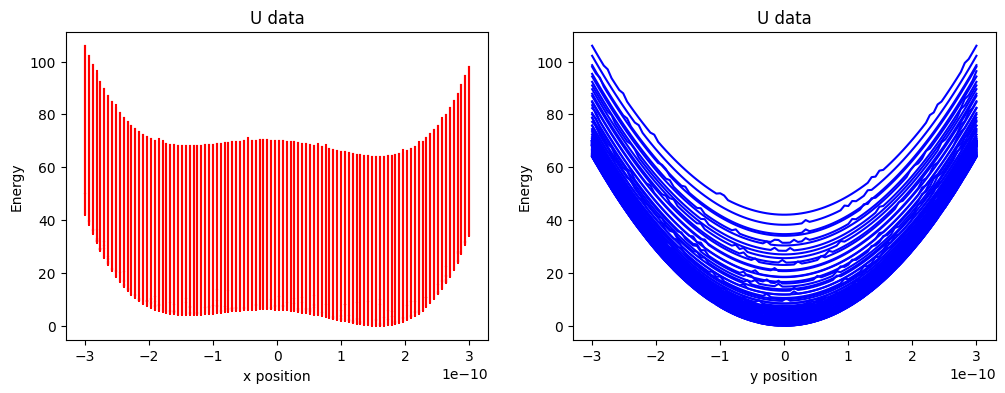

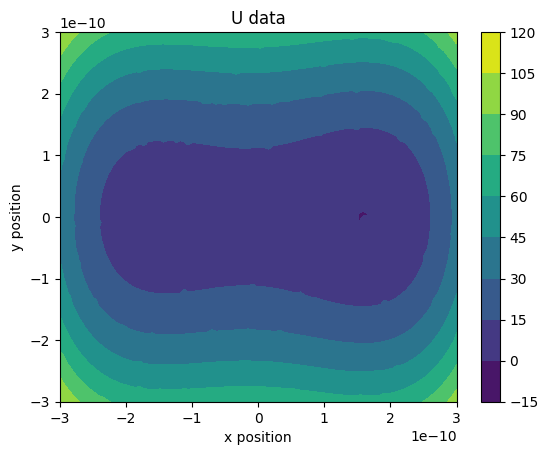

Text(0.5, 0.92, 'Quartic Potential')

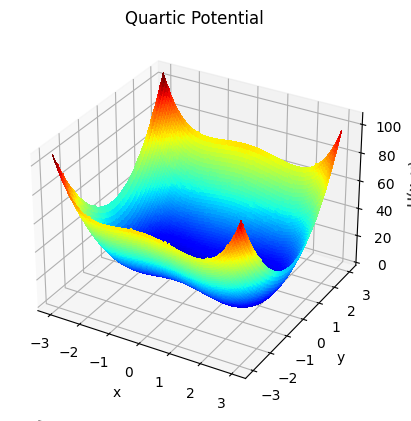

In [8]:
# Graph the data

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

# Potential - x vs. U
ax1.plot(x_vals, U_data, 'r')
ax1.set_xlabel('x position')
ax1.set_ylabel('Energy')
ax1.set_title('U data')

# Potential - y vs. U
ax2.plot(y_vals, U_data, 'b')
ax2.set_xlabel('y position')
ax2.set_ylabel('Energy')
ax2.set_title('U data')

plt.show()

# Potential - xy vs. U
plt.contourf(x,y, U_data)
plt.colorbar()
plt.title('U data')
plt.xlabel('x position')
plt.ylabel('y position')
plt.show()

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x_vals, y_vals, U_data, rstride=1, cstride=1,
                       cmap=plt.cm.jet, linewidth=0, antialiased=False)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('U(x, y)')
ax.set_title('Quartic Potential')